# DSCI 552 Assigment 5 Part 1

For [rod pumps](https://www.youtube.com/watch?v=nhxbfMG1y1s), a dynamometer card plots the stroke position (i.e., vertical displacement) of the pump versus the load on the pump.

The shape of dynamometer cards can be used to diagnosis problems, see:
* [Dyno Survey](https://www.downholediagnostic.com/dynamometer)
* [Dynamometer card common shapes and description](https://www.researchgate.net/figure/Dynamometer-card-common-shapes-and-description-Wang-et-al-2021_tbl1_354171410)


## Imports

In [ ]:
# All required imports are in this cell, User should add required imports if needed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import io

from sklearn.cluster import MiniBatchKMeans, KMeans, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import scatter_matrix
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Load Data

In [ ]:
# Defining the path as per the data location
data_link = "https://drive.google.com/uc?id=1JCdZusC6vtD2KzCvm3CGznVIBzK0_mKh"

# Fetch the content of the CSV file
response = requests.get(data_link).content
data_raw = pd.read_csv(io.StringIO(response.decode('utf-8')))

In [ ]:
data_raw

,WellName,CardDate,CardType,CardLocation,NumPoints,Position0,Position1,Position2,Position3,Position4,...,Load190,Load191,Load192,Load193,Load194,Load195,Load196,Load197,Load198,Load199
0,QFB 0,2014-01-01 03:41:30,POF,SU,200,85.50,85.50,86.00,86.25,86.50,...,4397.0,4343.0,4281.0,4207.0,4152.0,4121.0,4118.0,4077.0,4033.0,3933.0
1,QFB 1,2014-01-01 02:58:06,CUR,SU,200,48.00,48.00,48.00,47.75,47.75,...,3546.0,3602.0,3654.0,3687.0,3703.0,3690.0,3684.0,3683.0,3672.0,3588.0
2,QFB 2,2014-01-01 03:46:30,POF,SU,200,84.00,84.00,83.75,83.75,83.75,...,3039.0,3034.0,3031.0,3011.0,3000.0,2996.0,2997.0,3000.0,3002.0,2979.0
3,QFB 5,2014-01-01 02:38:54,CUR,SU,200,40.25,40.25,40.25,40.25,40.00,...,3023.0,3003.0,2983.0,2956.0,2926.0,2902.0,2884.0,2862.0,2827.0,2685.0
4,QFB 6,2014-01-01 02:50:36,CUR,SU,200,100.00,100.00,99.75,99.75,99.50,...,3678.0,3624.0,3636.0,3571.0,3590.0,3557.0,3528.0,3527.0,3519.0,3322.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,GTV 19H,2014-01-01 06:39:30,CUR,SU,200,0.50,0.50,0.75,1.00,1.25,...,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0
8177,GTV 20,2014-01-01 04:09:18,CUR,SU,200,48.00,48.00,48.00,47.75,47.75,...,2686.0,2684.0,2676.0,2664.0,2652.0,2641.0,2631.0,2623.0,2626.0,2626.0
8178,GTV 21,2014-01-01 03:26:30,CUR,SU,200,35.25,35.25,35.25,35.50,35.50,...,2501.0,2488.0,2477.0,2474.0,2470.0,2469.0,2466.0,2460.0,2455.0,2433.0
8179,GTV 22,2014-01-01 03:05:12,CUR,SU,200,36.00,36.00,36.00,35.75,35.75,...,2198.0,2202.0,2186.0,2177.0,2174.0,2151.0,2130.0,2121.0,2104.0,2110.0


## Initial data exploration

### TODO: Number of unique wells by WellName

In [ ]:
# Counting unique wells by WellName
unique_wells_by_name = data_raw['WellName'].nunique()

# Printing the number of unique wells by WellName
print("Number of Unique Wells by WellName:", unique_wells_by_name)

Number of Unique Wells by WellName: 8073


### TODO: Statistics on number of cards per well
Create DataFrame (or Series) to show number of wells that have only one card, only two cards, only three cards and so on.

In [ ]:
# Grouping the data by 'WellName' and counting the number of cards for each well
cards_per_well = data_raw.groupby('WellName').size()

# Counting the number of unique wells for each count of cards
wells_with_cards_count = cards_per_well.value_counts().sort_index()

# Creating a DataFrame or Series to display the counts
wells_with_cards_count_df = pd.DataFrame(wells_with_cards_count)
wells_with_cards_count_df.columns = ['Number of Wells']
wells_with_cards_count_df.index.name = 'Number of Cards'

print(wells_with_cards_count_df)

                 Number of Wells
Number of Cards                 
1                           7973
2                             92
3                              8


### Focus on cards with exactly 200 points

In [ ]:
# Filtering the data such that we have the cards that have 200 NumPoints
d200 = data_raw[data_raw['NumPoints']==200]
d200

,WellName,CardDate,CardType,CardLocation,NumPoints,Position0,Position1,Position2,Position3,Position4,...,Load190,Load191,Load192,Load193,Load194,Load195,Load196,Load197,Load198,Load199
0,QFB 0,2014-01-01 03:41:30,POF,SU,200,85.50,85.50,86.00,86.25,86.50,...,4397.0,4343.0,4281.0,4207.0,4152.0,4121.0,4118.0,4077.0,4033.0,3933.0
1,QFB 1,2014-01-01 02:58:06,CUR,SU,200,48.00,48.00,48.00,47.75,47.75,...,3546.0,3602.0,3654.0,3687.0,3703.0,3690.0,3684.0,3683.0,3672.0,3588.0
2,QFB 2,2014-01-01 03:46:30,POF,SU,200,84.00,84.00,83.75,83.75,83.75,...,3039.0,3034.0,3031.0,3011.0,3000.0,2996.0,2997.0,3000.0,3002.0,2979.0
3,QFB 5,2014-01-01 02:38:54,CUR,SU,200,40.25,40.25,40.25,40.25,40.00,...,3023.0,3003.0,2983.0,2956.0,2926.0,2902.0,2884.0,2862.0,2827.0,2685.0
4,QFB 6,2014-01-01 02:50:36,CUR,SU,200,100.00,100.00,99.75,99.75,99.50,...,3678.0,3624.0,3636.0,3571.0,3590.0,3557.0,3528.0,3527.0,3519.0,3322.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,GTV 19H,2014-01-01 06:39:30,CUR,SU,200,0.50,0.50,0.75,1.00,1.25,...,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0
8177,GTV 20,2014-01-01 04:09:18,CUR,SU,200,48.00,48.00,48.00,47.75,47.75,...,2686.0,2684.0,2676.0,2664.0,2652.0,2641.0,2631.0,2623.0,2626.0,2626.0
8178,GTV 21,2014-01-01 03:26:30,CUR,SU,200,35.25,35.25,35.25,35.50,35.50,...,2501.0,2488.0,2477.0,2474.0,2470.0,2469.0,2466.0,2460.0,2455.0,2433.0
8179,GTV 22,2014-01-01 03:05:12,CUR,SU,200,36.00,36.00,36.00,35.75,35.75,...,2198.0,2202.0,2186.0,2177.0,2174.0,2151.0,2130.0,2121.0,2104.0,2110.0


### TODO: Plot 10 card shapes
Generate one line plot of the first 10 cards.
* The x values should be positions d200.iloc[i, 5:205]
* The y values should be loads d200.iloc[i, 205:405]

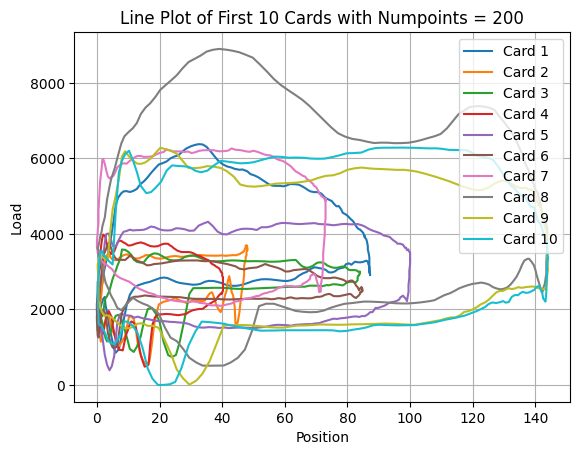

In [ ]:
# Selecting the first 10 cards from the filtered data where cards have NumPoints as 200
first_10_cards = d200.head(10)

# Plot each card
for i in range(10):
    x_values = first_10_cards.iloc[i, 5:205]
    y_values = first_10_cards.iloc[i, 205:405]
    plt.plot(x_values, y_values, label=f'Card {i+1}')

# Adding labels and legend
plt.xlabel('Position')
plt.ylabel('Load')
plt.title('Line Plot of First 10 Cards with Numpoints = 200')
plt.legend()
plt.grid(True)

# Displaying the plot
plt.show()

### TODO: Plot the load profiles
Generate one line plot of the profiles of first 10 cards, i.e., the x-axis is just range(200) and y-axis is load.

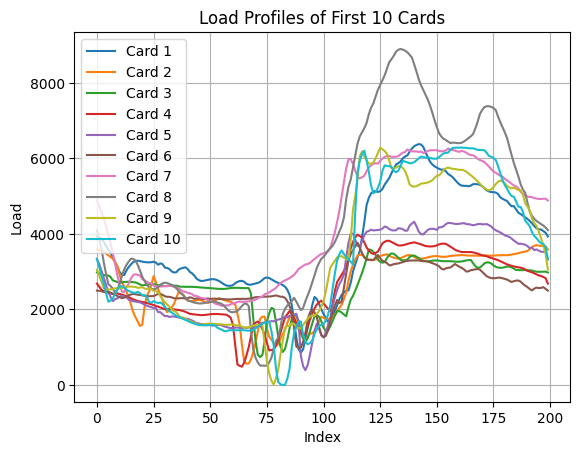

In [ ]:
# Selecting the first 10 cards from the filtered data where cards have 200 NumPoints
first_10_cards = d200.head(10)

# Plot each card
for i in range(10):
    y_values = first_10_cards.iloc[i, 205:405]
    plt.plot(range(200), y_values, label=f'Card {i+1}')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Load')
plt.title('Load Profiles of First 10 Cards')
plt.legend()
plt.grid(True)

# Displaying the plot
plt.show()

### TODO: Plot the position profiles
Generate one line plot of the position of first 10 cards, i.e., the x-axis is range(200) and y-axis is position.

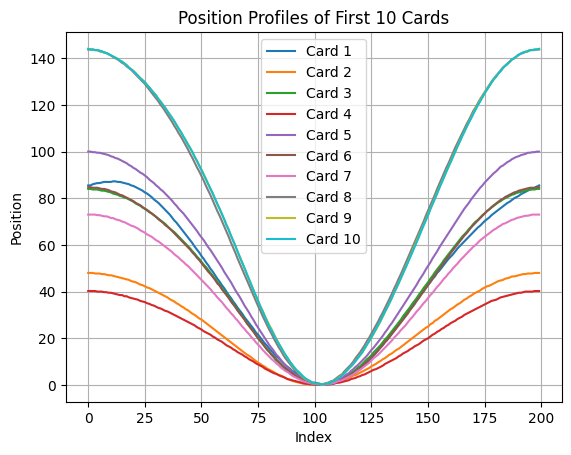

In [ ]:
# Selecting the first 10 cards from the filtered data where cards have 200 NumPoints
first_10_cards = d200.iloc[:10, 5:205]

# Plot each card
for i in range(10):
    plt.plot(range(200), first_10_cards.iloc[i], label=f'Card {i+1}')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Position')
plt.title('Position Profiles of First 10 Cards')
plt.legend()
plt.grid(True)

# Displaying the plot
plt.show()

### TODO: Position Profiles
What do the the position profiles look

**ANSWER**

The position profile of a card in this dataset likely indicate 200 different positions of the card and we may also plot it against load to see how load varies as the position changes for each card across the 200 positions. Each line in the plot represents the position profile of a single card.

Trends or Patterns in the position profiles could indicate areas of concern or interest for further investigation or optimization. If the position profile is relatively flat, it suggests that the card maintains a consistent position value. Conversely, if there are significant peaks or valleys in the position profile, it indicates that the position of the card varies widely across the range.

Examining the position profiles can provide insights into the behavior and characteristics of the cards, such as whether they are stable or exhibit significant fluctuations in position.

### TODO: Max position profiles
Plot position curves using max values over all cards

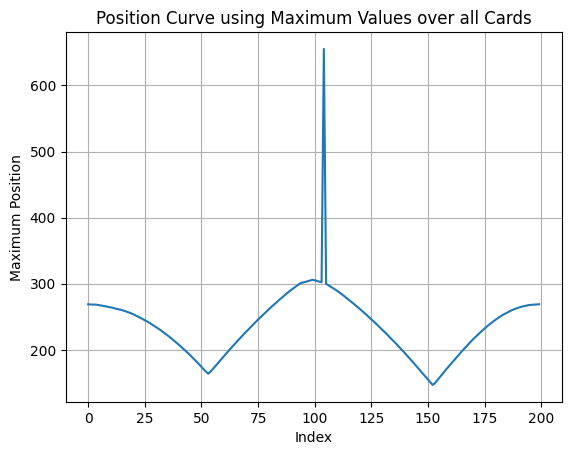

In [ ]:
# Finding the maximum position values over all cards in d200
max_position_values = d200.iloc[:, 5:205].max()

# Plot the aggregated position profile curve
plt.plot(range(200), max_position_values)
plt.xlabel('Index')
plt.ylabel('Maximum Position')
plt.title('Position Curve using Maximum Values over all Cards')
plt.grid(True)
plt.show()

### TODO: Comment on the max position profiles
Based on the first position plot of the first 10 cards, what max profile were you expecting?

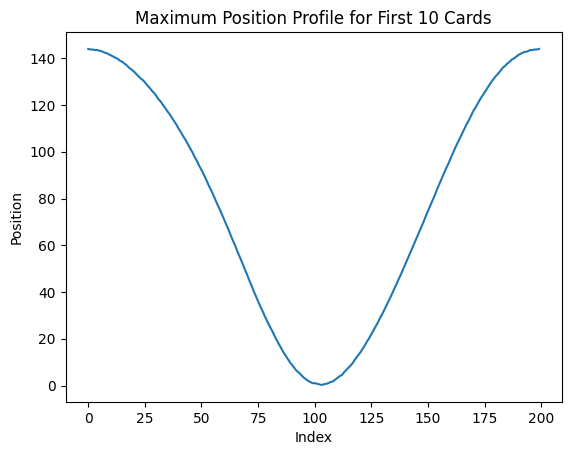

In [ ]:
# Calculating the maximum position profile values for the first 10 cards
max_position_values_first_10_cards = d200.iloc[:10, 5:205].max(axis=0)

# Plot the maximum position profile values for the first 10 cards
plt.plot(range(200), max_position_values_first_10_cards)
plt.xlabel('Index')
plt.ylabel('Position')
plt.title('Maximum Position Profile for First 10 Cards')
plt.show()

**ANSWER**


Based on the position profile plot of the first 10 cards, I would expect the max profile to exhibit a smooth, bell-shaped curve with its peak around the middle of the range of positions (around index 100-105), gradually increasing from the edges towards the peak, and then gradually decreasing again towards the end.

This expectation arises from the observation that in the position profile plot of all cards, The cards generally start with lower position values, increase to a maximum value around the middle, and then decrease towards the end. This pattern suggests that the maximum position profile would also follow a similar trend, reflecting the maximum position values across the 200 positions for the first 10 cards.

To further explain this maximum position profile, additional plots could be generated:

Histogram of Position Values: A histogram showing the distribution of position values across all cards could provide insights into the frequency of occurrence of different position values.

Box Plot of Position Values: A box plot showing the distribution of position values for each position index could help visualize the variability and central tendency of the position values at different points across all cards.

Kernel Density Estimation (KDE) Plot: A KDE plot could be used to estimate the probability density function of the position values, providing a smooth representation of the distribution of position values.

These plots would complement the position plot and help in further understanding the distribution and characteristics of the position values, supporting the interpretation of the max profile.

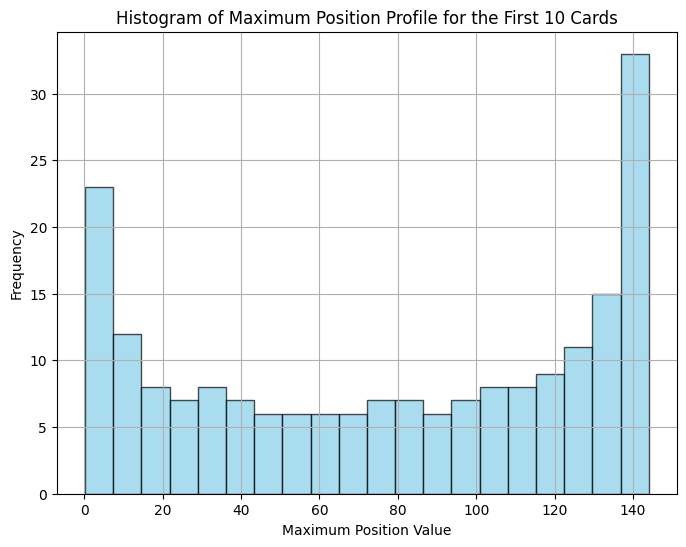

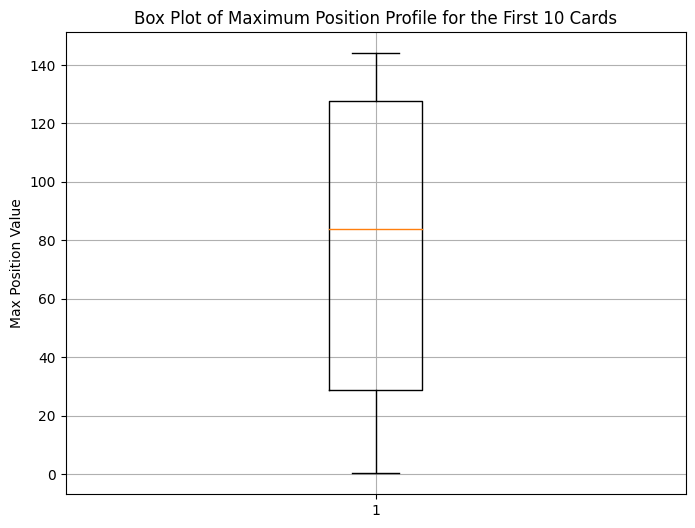

In [ ]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(max_position_values_first_10_cards, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Maximum Position Profile for the First 10 Cards')
plt.xlabel('Maximum Position Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(max_position_values_first_10_cards)
plt.title('Box Plot of Maximum Position Profile for the First 10 Cards')
plt.ylabel('Max Position Value')
plt.grid(True)
plt.show()

### TODO: Plot min position profile

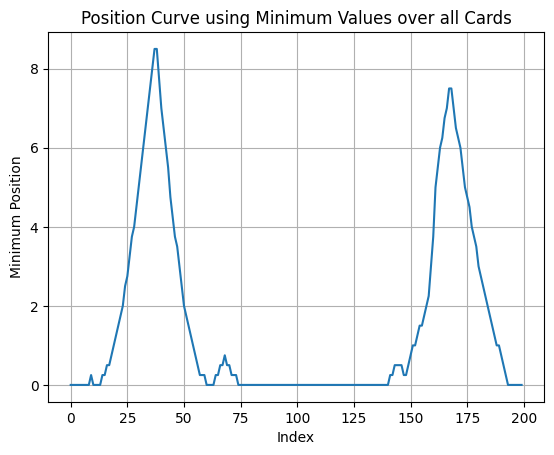

In [ ]:
# Finding the minimum position values over all cards in d200
min_positions = d200.iloc[:, 5:205].min(axis=0)

# Plot the aggregated position profile curve
plt.plot(range(200), min_positions)
plt.xlabel('Index')
plt.ylabel('Minimum Position')
plt.title('Position Curve using Minimum Values over all Cards')
plt.grid(True)
plt.show()

### TODO: Comment on the min position profiles
Based on the first position plot of the first 10 cards, what min profile were you expecting?
How would you explain this min profile? Generate more plots to explain this min profile.

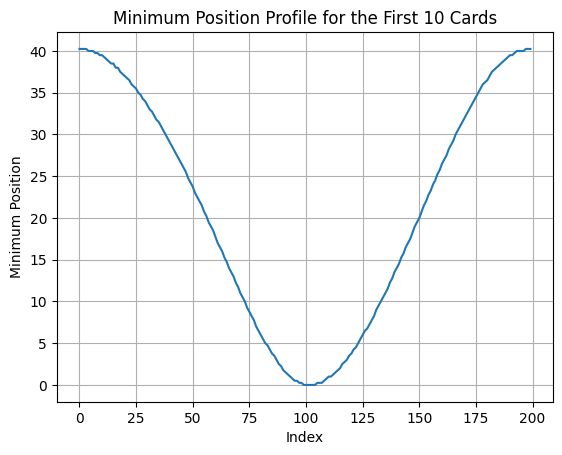

In [ ]:
# Find the minimum position values over all cards for the first 10 cards
min_position_values_first_10 = d200.iloc[:10, 5:205].min()

# Plot the minimum position values for the first 10 cards
plt.plot(range(200), min_position_values_first_10)
plt.xlabel('Index')
plt.ylabel('Minimum Position')
plt.title('Minimum Position Profile for the First 10 Cards')
plt.grid(True)
plt.show()

**ANSWER**

Based on the position profile plot of the first 10 cards, the expected minimum profile would likely exhibit a similar trend as the individual position profile plots for each card. Since we're considering the minimum position at each index across all cards, we would expect the minimum profile to represent the lowest position value observed at each position index across the first 10 cards.

To further explain this minimum position profile, you can generate additional plots such as histograms or box plots to visualize the distribution of minimum position values across all cards or for specific subsets of cards. These plots can provide insights into the variability and distribution of minimum position values, helping to understand the overall behavior of the card positions.

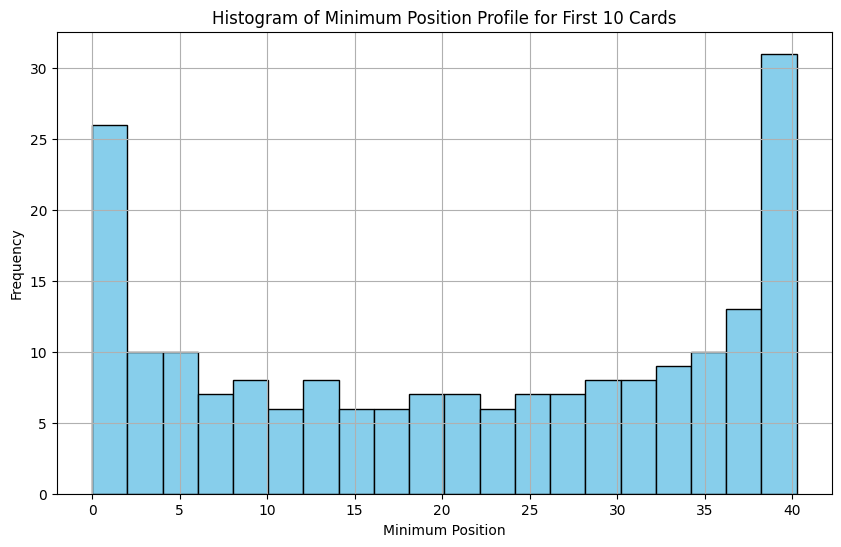

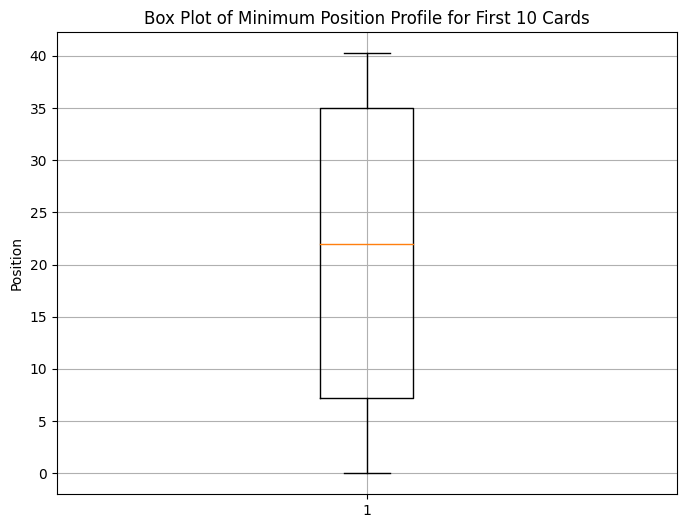

In [ ]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(min_position_values_first_10, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Minimum Position Profile for First 10 Cards')
plt.xlabel('Minimum Position')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(min_position_values_first_10)
plt.title('Box Plot of Minimum Position Profile for First 10 Cards')
plt.ylabel('Position')
plt.grid(True)
plt.show()


# Remove outlier

## TODO: find outlier card

Which card caused the peak around position 105?

In [ ]:
# Finding the index of the card with the maximum value at Position 105 we used Position 104 because the indexing start from 0 and the label is Position 104 according to the data
max_position_105_index = d200['Position104'].idxmax()

# Get the value at Position 105 of the card
peak_value = d200.loc[max_position_105_index, 'Position104']

# Print the attributes, index, and value at Position 105 of the card
print("Outlier Card:")
print(d200.loc[max_position_105_index, ['WellName', 'CardDate', 'CardType', 'CardLocation', 'NumPoints']])
print("\nIndex of the card in raw data:", max_position_105_index)
print("\nPeak value:", peak_value)

for i in range(len(d200)):
  if (d200.iloc[i]['Position104'] == peak_value):
    d200_max_position_105_index = i
    break

print("\nIndex of the card in d200:", d200_max_position_105_index)

Outlier Card:
WellName                     GGW 30
CardDate        2014-01-01 04:49:42
CardType                        CUR
CardLocation                     SU
NumPoints                       200
Name: 8026, dtype: object

Index of the card in raw data: 8026

Peak value: 655.25

Index of the card in d200: 6309


### TODO: plot this oulier card

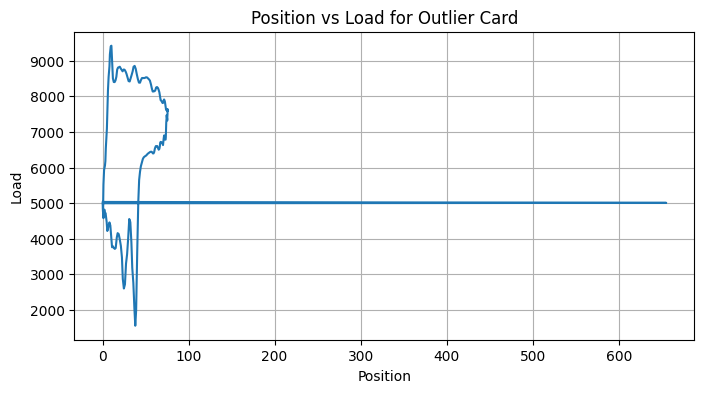

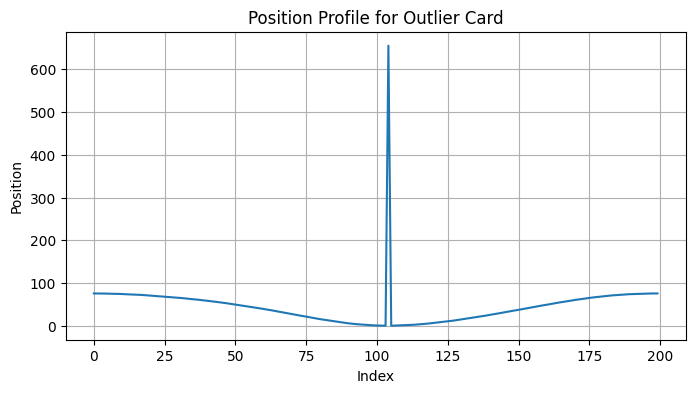

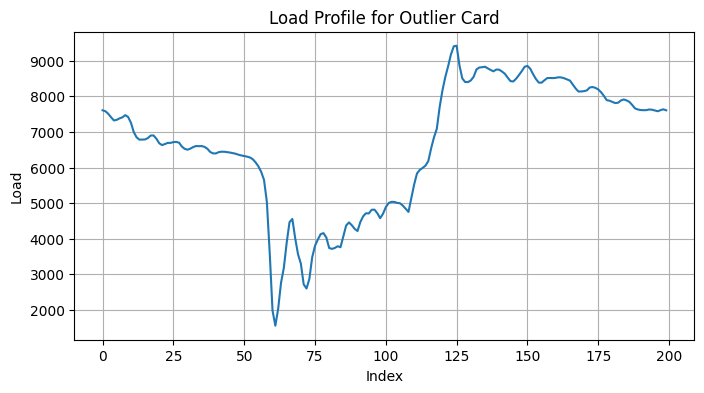

In [ ]:
outlier_card = d200.iloc[d200_max_position_105_index]

# Extracting the position and load data for the outlier card
position_data = outlier_card.iloc[5:205].values
load_data = outlier_card.iloc[205:405].values

# Extracting position and load data for the outlier card
position_data = outlier_card.iloc[5:205].values
load_data = outlier_card.iloc[205:405].values

# Plot the position data against the load data
plt.figure(figsize=(8, 4))
plt.plot(position_data, load_data)
plt.xlabel('Position')
plt.ylabel('Load')
plt.title('Position vs Load for Outlier Card')
plt.grid(True)
plt.show()

# Plot the position profile data
plt.figure(figsize=(8, 4))
plt.plot(range(200), position_data)
plt.xlabel('Index')
plt.ylabel('Position')
plt.title('Position Profile for Outlier Card')
plt.grid(True)
plt.show()

# Plot the load profile data
plt.figure(figsize=(8, 4))
plt.plot(range(200), load_data)
plt.xlabel('Index')
plt.ylabel('Load')
plt.title('Load Profile for Outlier Card')
plt.grid(True)
plt.show()

### TODO: Create a new dataset by removing this outlier

In [ ]:
# Creating a new dataset called d200_clean by removing the outlier card from the data
d200_clean = d200.drop(max_position_105_index)

# Displaying the cleaned dataset
print(d200_clean)

     WellName             CardDate CardType CardLocation  NumPoints  \
0       QFB 0  2014-01-01 03:41:30      POF           SU        200   
1       QFB 1  2014-01-01 02:58:06      CUR           SU        200   
2       QFB 2  2014-01-01 03:46:30      POF           SU        200   
3       QFB 5  2014-01-01 02:38:54      CUR           SU        200   
4       QFB 6  2014-01-01 02:50:36      CUR           SU        200   
...       ...                  ...      ...          ...        ...   
8176  GTV 19H  2014-01-01 06:39:30      CUR           SU        200   
8177   GTV 20  2014-01-01 04:09:18      CUR           SU        200   
8178   GTV 21  2014-01-01 03:26:30      CUR           SU        200   
8179   GTV 22  2014-01-01 03:05:12      CUR           SU        200   
8180   GTV 23  2014-01-01 06:33:54      CUR           SU        200   

      Position0  Position1  Position2  Position3  Position4  ...  Load190  \
0         85.50      85.50      86.00      86.25      86.50  ...   439

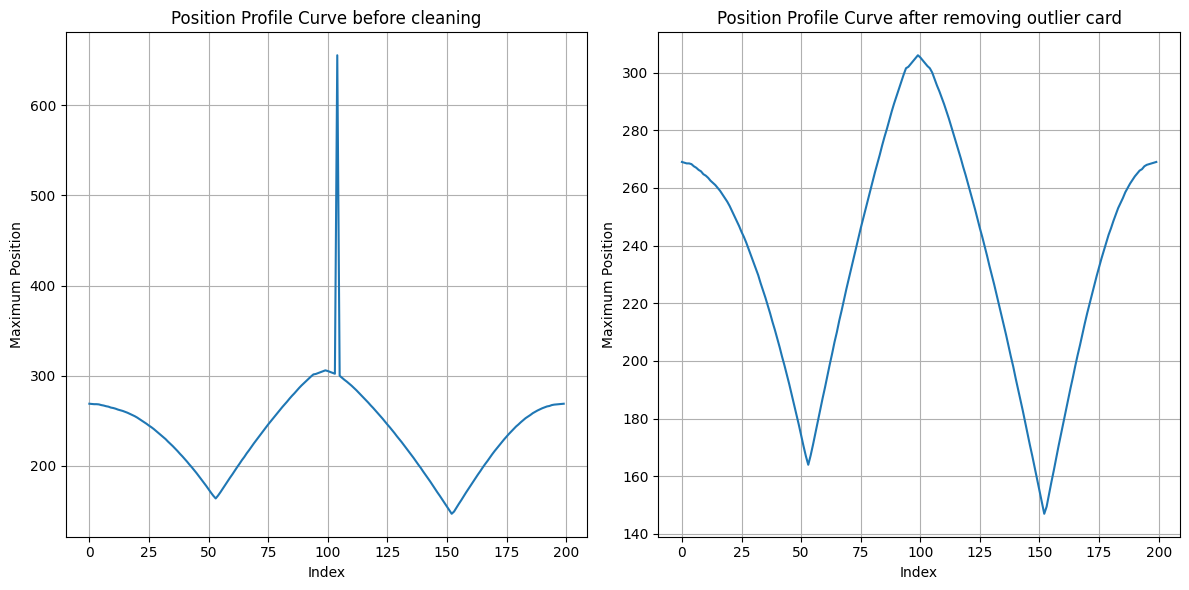

In [ ]:
# Find the maximum position values over all cards for the original data
max_position_values_original = d200.iloc[:, 5:205].max()

# Find the maximum position values over all cards for the cleaned data
max_position_values_cleaned = d200_clean.iloc[:, 5:205].max()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the aggregated position curve for original data
axes[0].plot(range(200), max_position_values_original)
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Maximum Position')
axes[0].set_title('Position Profile Curve before cleaning')
axes[0].grid(True)

# Plot the aggregated position curve for cleaned data
axes[1].plot(range(200), max_position_values_cleaned)
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Maximum Position')
axes[1].set_title('Position Profile Curve after removing outlier card')
axes[1].grid(True)

# Adjust layout to prevent overlap of labels
plt.tight_layout()

# Display the plots
plt.show()

# Dimensionality Reduction

Let's continou analyzing the positions using PCA

### TODO: Project the positions down to 10 dimensions using PCA

Store the resulting project as a DataFrame in `pos_pca`

In [ ]:
# Initializing PCA with 10 components
pca = PCA(n_components=10)

# Fitting PCA to the position data
pos_pca = pca.fit_transform(d200_clean.iloc[:, 5:205])

# Creating a DataFrame for the projected positions
pos_pca = pd.DataFrame(pos_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

# Displaying the projected positions DataFrame (all the 10 Principal Components)
print(pos_pca)

             PC1         PC2        PC3       PC4        PC5       PC6  \
0      70.568303  -23.345583  21.771193  1.087419  26.136953 -6.190017   
1    -282.244565  -43.499827  -8.244407  0.119839  -0.026203  0.484792   
2      53.691839  -23.059171  -5.564845 -7.111223  -0.031971 -0.691657   
3    -352.834984  -46.436220   2.053790  0.532000  -2.594816  0.575666   
4     195.802481  -16.624854  -0.523614 -5.289120   0.129586  1.827686   
...          ...         ...        ...       ...        ...       ...   
6440 -423.689527  667.007733  36.721162 -5.707008  10.268989  4.192104   
6441 -284.885509  -45.644599  -6.945387  2.112738  -1.851241 -0.131013   
6442 -391.086149  -43.839544  24.257658 -2.092929   1.213282 -0.732830   
6443 -401.147231  -52.964228  18.565401  8.105853  -7.601443  0.009231   
6444 -286.338048  -30.917336  72.464037  4.555802   5.736455 -1.648664   

           PC7       PC8       PC9      PC10  
0    -7.635062  2.414929  0.776492 -0.488164  
1     0.386717 -0

### TODO: Using a single figure to plot the first five principal components

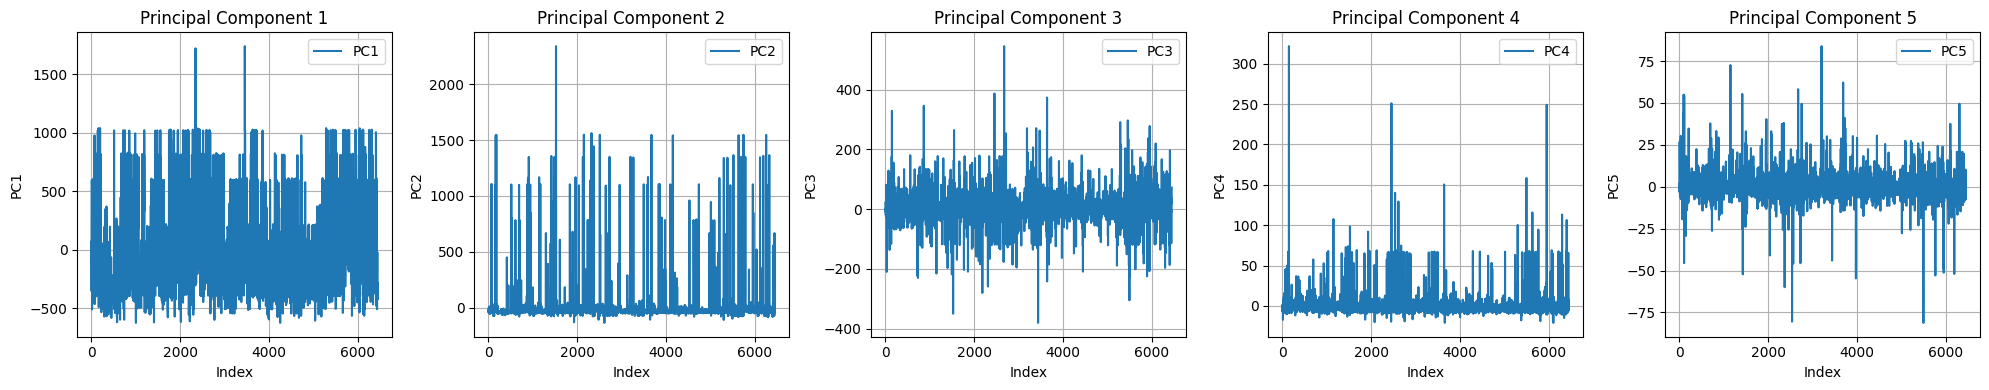

In [ ]:
# Creating a figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Plot the sactter for the first five principal components
for i in range(5):
    axes[i].plot(pos_pca.iloc[:, i], label=f'PC{i+1}')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'PC{i+1}')
    axes[i].set_title(f'Principal Component {i+1}')

# Adding legend and grid
for ax in axes:
    ax.legend()
    ax.grid(True)

# Adjust the layout
plt.tight_layout()

# Displaying the plot
plt.show()

### TODO: Create scatter plot using first two coordinates of the PCA transformed coordinates

You should see to distinct clusters.

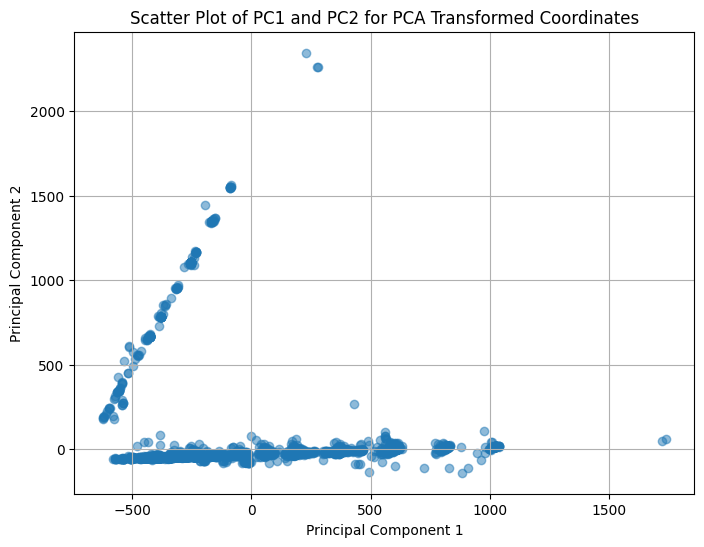

In [ ]:
# Creating the scatter plot of first two components
plt.figure(figsize=(8, 6))
plt.scatter(pos_pca.iloc[:, 0], pos_pca.iloc[:, 1], alpha=0.5)

# Adding the labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PC1 and PC2 for PCA Transformed Coordinates')

# Displaying the plot
plt.grid(True)
plt.show()

### TODO: Generate position profiles plots for each of the two clusters

Draw profiles by sampling from each of the clusters.

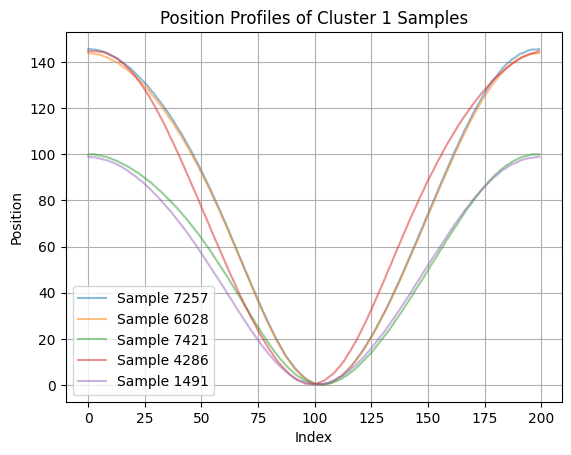

In [ ]:
# Here, we use KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(pos_pca)

# Plot the for Position Profiles of samples from Cluster 1
cluster_samples_1 = d200_clean[cluster_labels == 0].sample(n=5, random_state=42)
for index, row in cluster_samples_1.iterrows():
    plt.plot(range(200), row[5:205], label=f"Sample {index}", alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Position')
plt.title('Position Profiles of Cluster 1 Samples')
plt.legend()
plt.grid(True)
plt.show()

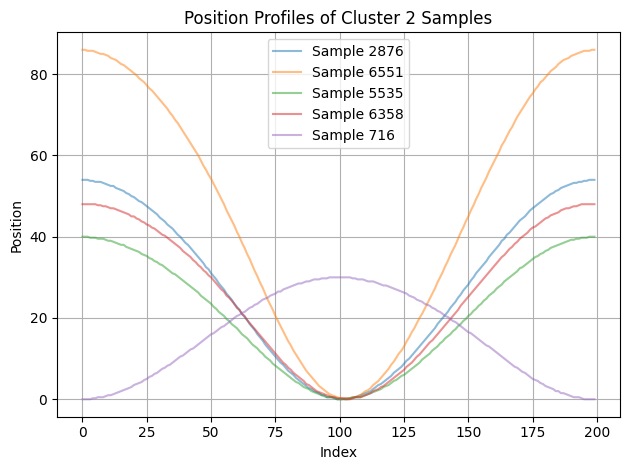

In [ ]:
# Plot the for Position Profiles of samples from Cluster 2
cluster_samples_2 = d200_clean[cluster_labels == 1].sample(n=5, random_state=42)
for index, row in cluster_samples_2.iterrows():
    plt.plot(range(200), row[5:205], label=f"Sample {index}", alpha=0.5)

plt.xlabel('Index')
plt.ylabel('Position')
plt.title('Position Profiles of Cluster 2 Samples')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### TODO: What do the clusters represent?

**ANSWER**

The clusters obtained from the KMeans algorithm represent cards (groups of data points) with similar variations in position ranges (position profiles). The clusters represent different patterns or distributions of the position profiles of the cards that exhibit similar behaviour aross the given 200 positions range.

### TODO: What does principal component one, i.e.pos_pca[:, 0], represent?

Let's focus on just the "cosine" position curves.  Sample various pos_pca[:, 0] from small to large, and plot corresponding position curves.

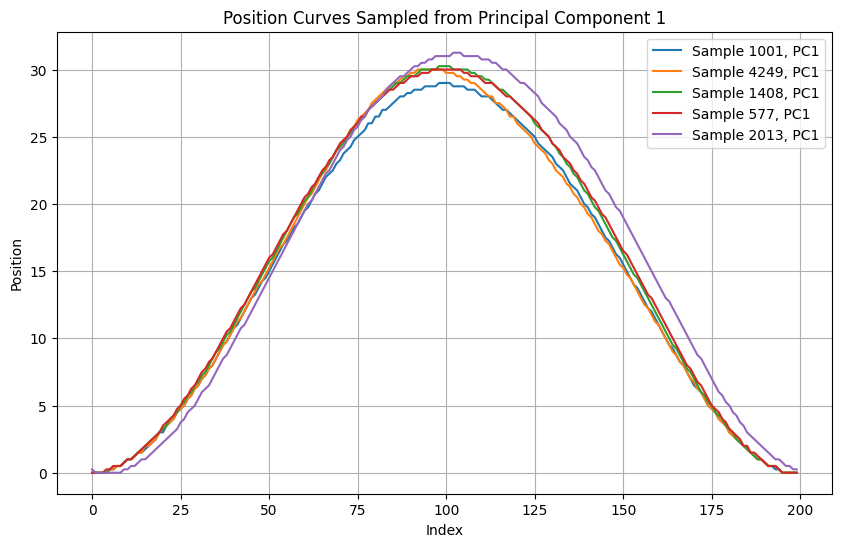

In [ ]:
# Sorting pos_pca[:, 0] to sample from small to large
sorted_indices = np.argsort(pos_pca.iloc[:, 0])

# Sample positions based on sorted pos_pca[:, 0] values
num_samples = 5  # Number of samples to plot
sampled_indices = sorted_indices[:num_samples]

# Plot sampled position curves
plt.figure(figsize=(10, 6))
plt.title('Position Curves Sampled from Principal Component 1')

for i, index in enumerate(sampled_indices):
    profile = d200_clean.iloc[index, 5:205]  # Extracting position profile
    plt.plot(profile, label=f'Sample {index}, PC1')

plt.xticks(range(0, 201, 25), range(0, 201, 25))
plt.xlabel('Index')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()

**ANSWER**

Principal Component 1 (PC1), represented by pos_pca[:, 0], is the first principal component obtained from the PCA transformation of the original card shape data. It is a linear combination of the original features (in this case, the position data) that captures the maximum variance in the data (position distribution in our case).

In the context of position data, PC1 represent the dominant pattern or trend across the positions of the data points. It can be interpreted as the direction in the data space along which the variability is the highest. Therefore, PC1 provides insight into the most significant patterns or trends present in the position data (compared to other principal components PC1 exhibit highest variance).

### TODO: Plot Scatter Matrix
Plot the 5x5 scatter matrix using the first five dimensions of the pos_pca points

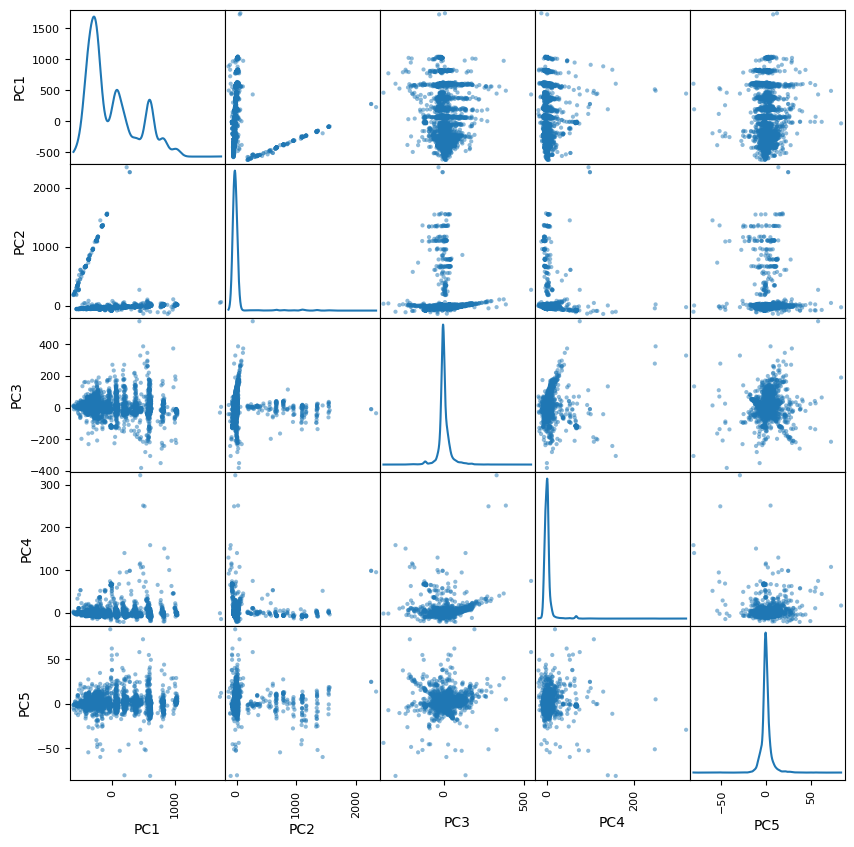

In [ ]:
# Extracting the first five dimensions of the pos_pca DataFrame
pos_pca_first_five = pos_pca.iloc[:, :5]

# Plot the 5x5 scatter matrix with KDE for smoothening on the diagonal
scatter_matrix(pos_pca_first_five, figsize=(10, 10), diagonal='kde')
plt.show()

### TODO: What does principal component three, i.e. pos_pca[:, 2], represent?

Let's focus on just the "cosine" position curves.  Generate a figure with position curves with very small pos_pca[:, 2] and very large pos_pca[:, 2] values.

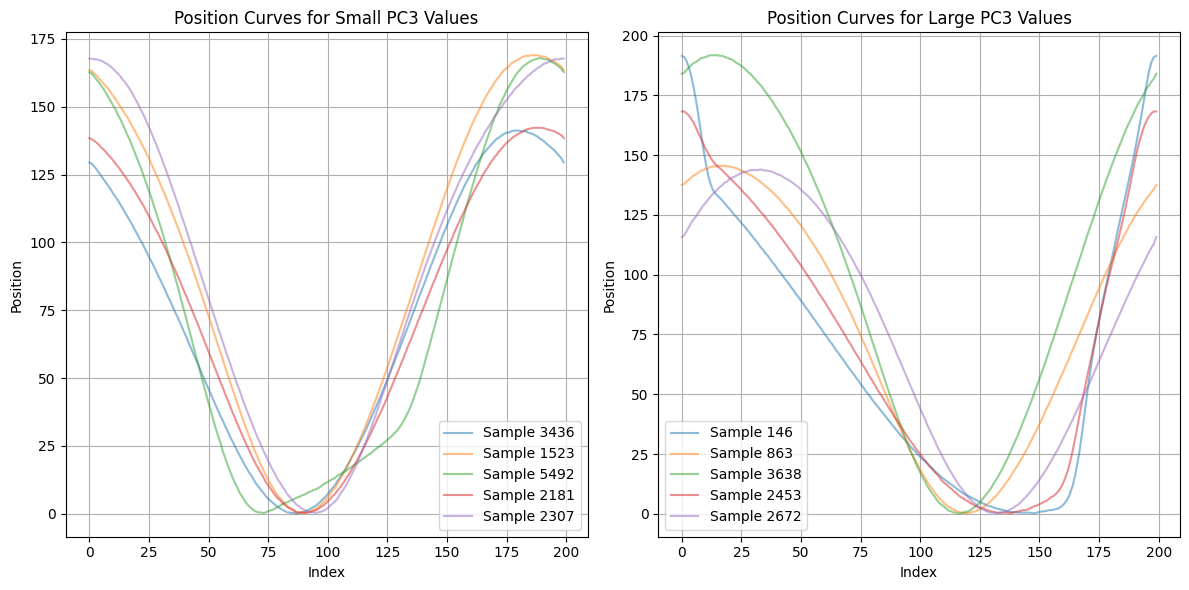

In [ ]:
# Sorting the pos_pca DataFrame based on pos_pca[:, 2]
pos_pca_sorted = pos_pca.iloc[pos_pca.iloc[:, 2].argsort()]

# Selecting the position curves corresponding to very small and very large values of pos_pca[:, 2]
num_curves = 5
small_values_indices = pos_pca_sorted.iloc[:num_curves].index
large_values_indices = pos_pca_sorted.iloc[-num_curves:].index

# Plot position curves for small values of pos_pca[:, 2]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for index in small_values_indices:
    plt.plot(range(200), d200_clean.iloc[index, 5:205], label=f"Sample {index}", alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Position')
plt.title('Position Curves for Small PC3 Values')
plt.legend()
plt.grid(True)

# Plot position curves for large values of pos_pca[:, 2]
plt.subplot(1, 2, 2)
for index in large_values_indices:
    plt.plot(range(200), d200_clean.iloc[index, 5:205], label=f"Sample {index}", alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Position')
plt.title('Position Curves for Large PC3 Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Answer**

Principal Component Three (pos_pca[:, 2]) represents the third principal component obtained from the PCA transformation of the original data. Each principal component captures a different direction of maximum variance in the data. Therefore, pos_pca[:, 2] represents the data points projected onto the axis that captures the third most significant source of variability (variance) in the data (after Principal Compnent 1 - PC1 and Principal Component - PC2).

# Clustering

## KMeans



### TODO: Generate KMeans clustering

Use KMeans clustering to cluster the pos_pca DataFrame. Select a large number for k, say k=40.

In [ ]:
# Number of clusters
k = 40

# Performing KMeans clustering
kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
kmeans_cluster_labels = kmeans.fit_predict(pos_pca)

# Obtaining cluster centers
kmeans_cluster_centers = kmeans.cluster_centers_

print("Cluster Labels after K-Means Clustering: ", kmeans_cluster_labels)

Cluster Labels after K-Means Clustering:  [ 3 19  3 ... 36  9 30]


### TODO: Plot the position profile of each of the cluster centers.

Use the PCA.inverser_transform() method to map the pca coordinate points back to the positions.

Note: inverser_transform() is just a convenience for:  pos_pca @ pca_clean.components_ + pca_clean.mean_



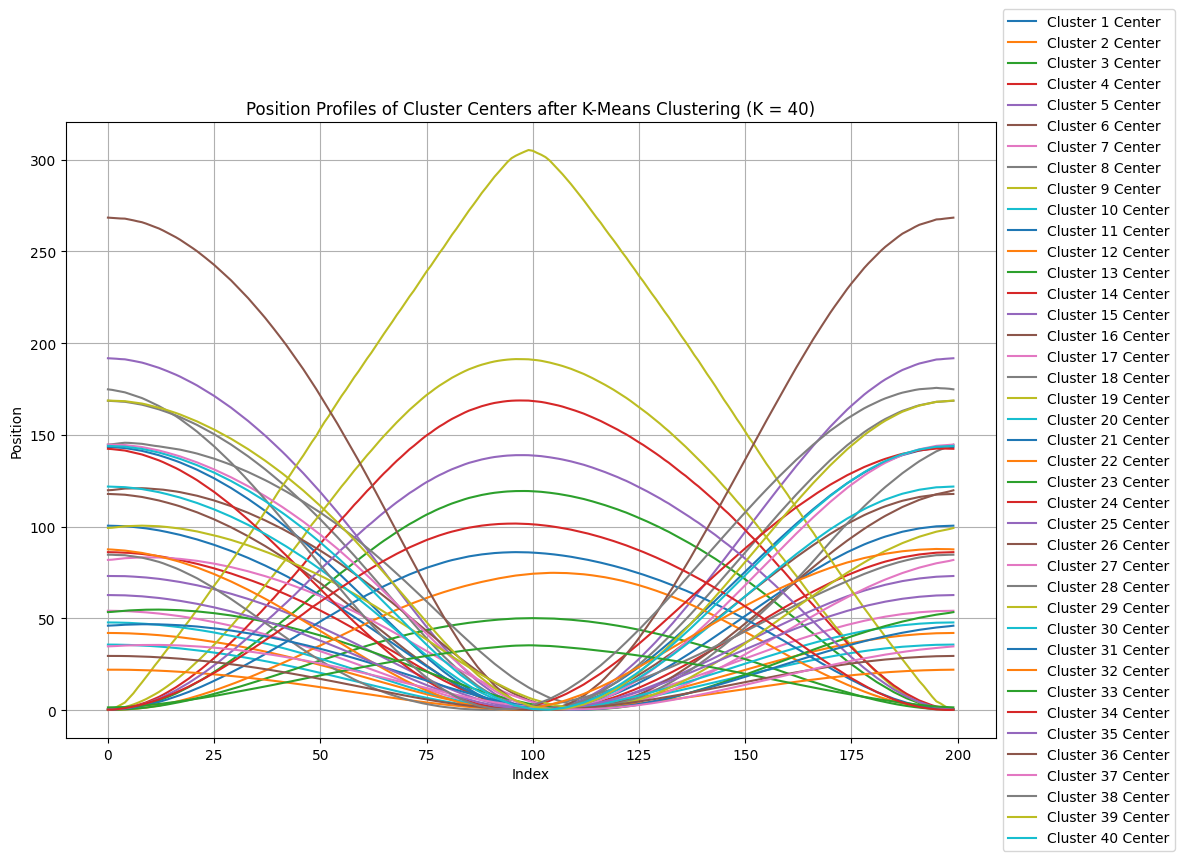

In [ ]:
kmeans_cluster_centers_transformed = pca.inverse_transform(kmeans.cluster_centers_)

# Plot the position profile of each cluster center
plt.figure(figsize=(12, 8))
for i, center in enumerate(kmeans_cluster_centers_transformed):
    plt.plot(center, label=f'Cluster {i+1} Center')
plt.xlabel('Index')
plt.ylabel('Position')
plt.title('Position Profiles of Cluster Centers after K-Means Clustering (K = 40)')

# Add legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

### TODO: Plot Scatter Matrix

Plot scatter matrix of just the cluster centers using PCA components as axis.

Compare this scatter matrix of cluster centers with the the scatter matrix of all points to check if kMeans centers are representative of all the points

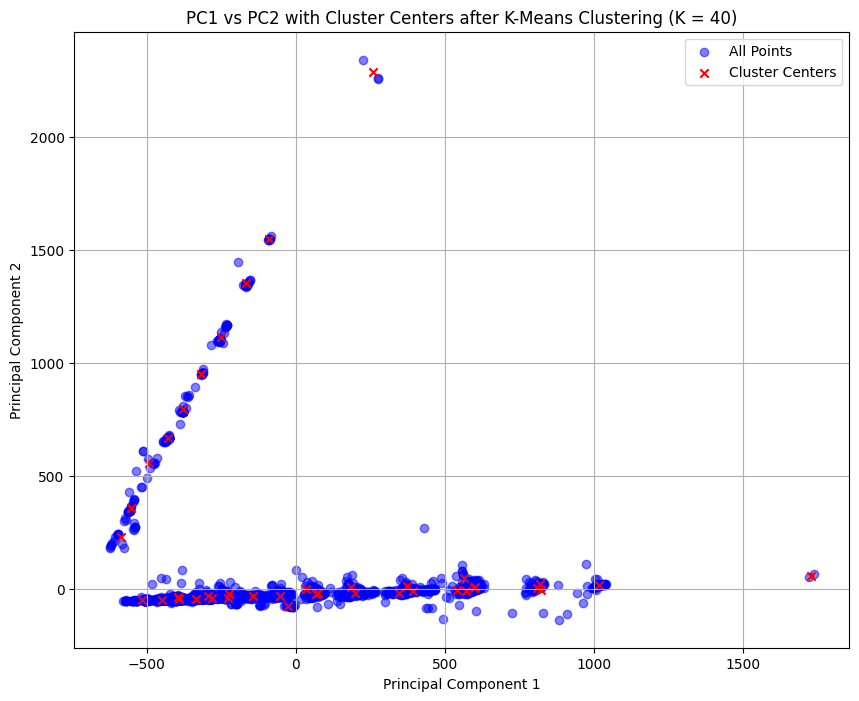

In [ ]:
# Plot PCA1 vs PCA2 for all points - we can check for more components if required
plt.figure(figsize=(10, 8))
plt.scatter(pos_pca['PC1'], pos_pca['PC2'], color='blue', alpha=0.5, label='All Points')

# Plot cluster centers using red x
plt.scatter(kmeans_cluster_centers[:, 0], kmeans_cluster_centers[:, 1], color='red', marker='x', label='Cluster Centers')

# Adding labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PC1 vs PC2 with Cluster Centers after K-Means Clustering (K = 40)')

# Displaying the plot
plt.legend()
plt.grid(True)
plt.show()

### TODO: Generate Inset Plots

Create an inset plot with principal component 1 and principal component 2 as the axis. This plot is similar to the scatter plot, except instead of plotting points plot the position curves that correspond to the point.

See [inset_axes()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.inset_axes.html) method.

Your plot should look something like this:

![image.png](sample.png)

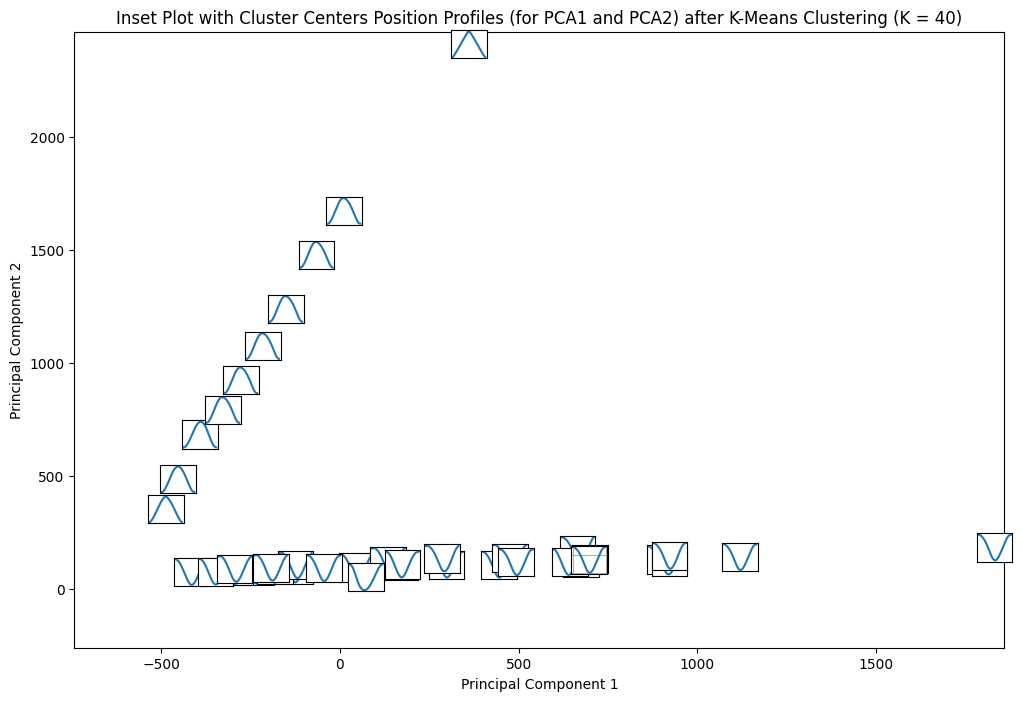

In [ ]:
# Creating a figure and axis for PCA1 vs PCA2 plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot PCA1 vs PCA2 for all points but our visibility is none to enhance the inset plots
scatter = ax.scatter(pos_pca['PC1'], pos_pca['PC2'], color='white', alpha=0.5, label='All Points')

# Adding labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Inset Plot with Cluster Centers Position Profiles (for PCA1 and PCA2) after K-Means Clustering (K = 40)')


# Adding inset axes plots for position profiles
for i, center in enumerate(kmeans_cluster_centers):
    # Creating inset axes with custom location - cluster centers and larger size
    ax_inset = inset_axes(ax, width="50%", height="50%", loc='center', bbox_to_anchor=(center[0], center[1], 200, 250), bbox_transform=ax.transData)

    # Plotting each position profile in inset
    ax_inset.plot(kmeans_cluster_centers_transformed[i])

    # Removing x-labels and y-labels
    ax_inset.set_xticklabels([])
    ax_inset.set_yticklabels([])
    ax_inset.tick_params(axis='both', which='both', length=0)

# Displaying the plot
plt.grid(True)
plt.show()

## Affinity Propagation

[Affinity Propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation) is clustering technique that unlike kmeans does not require the number of clusters as input.

However, affinity propagation can be slow and sometime it may not converge with the default `max_iter=200`.

Generate a clustering using affinity propagation using the position values `d200_clean.iloc[:, 5:205]` directly, instead of PCA projected values. Adjust these parameters as need to make sure affinity propagation converges.

* `max_iter`
* `damping`

### TODO: Generate Affinity Propagration Clustering

In [ ]:
%%time

# Extracting the position profile values
position_profile_values = d200_clean.iloc[:, 5:205]

# Adjusting parameters for Affinity Propagation
max_iter = 500  # Increase max_iter for better chance of convergence
damping = 0.95  # Set damping factor to promote convergence

# Performing Affinity Propagation clustering
affinity_propagation = AffinityPropagation(max_iter=max_iter, damping=damping)
affinity_propagation_cluster_labels = affinity_propagation.fit_predict(position_profile_values)

# Number of clusters
k = len(np.unique(affinity_propagation_cluster_labels))

# Printing the number of clusters and cluster labels
print("Number of clusters:", k)
print("Cluster labels:", affinity_propagation_cluster_labels)

Number of clusters: 40
Cluster labels: [36  9 36 ... 27  6 19]
CPU times: user 1min 51s, sys: 1.8 s, total: 1min 52s
Wall time: 1min 54s


### TODO: Generate plot of position curves of the cluster centers

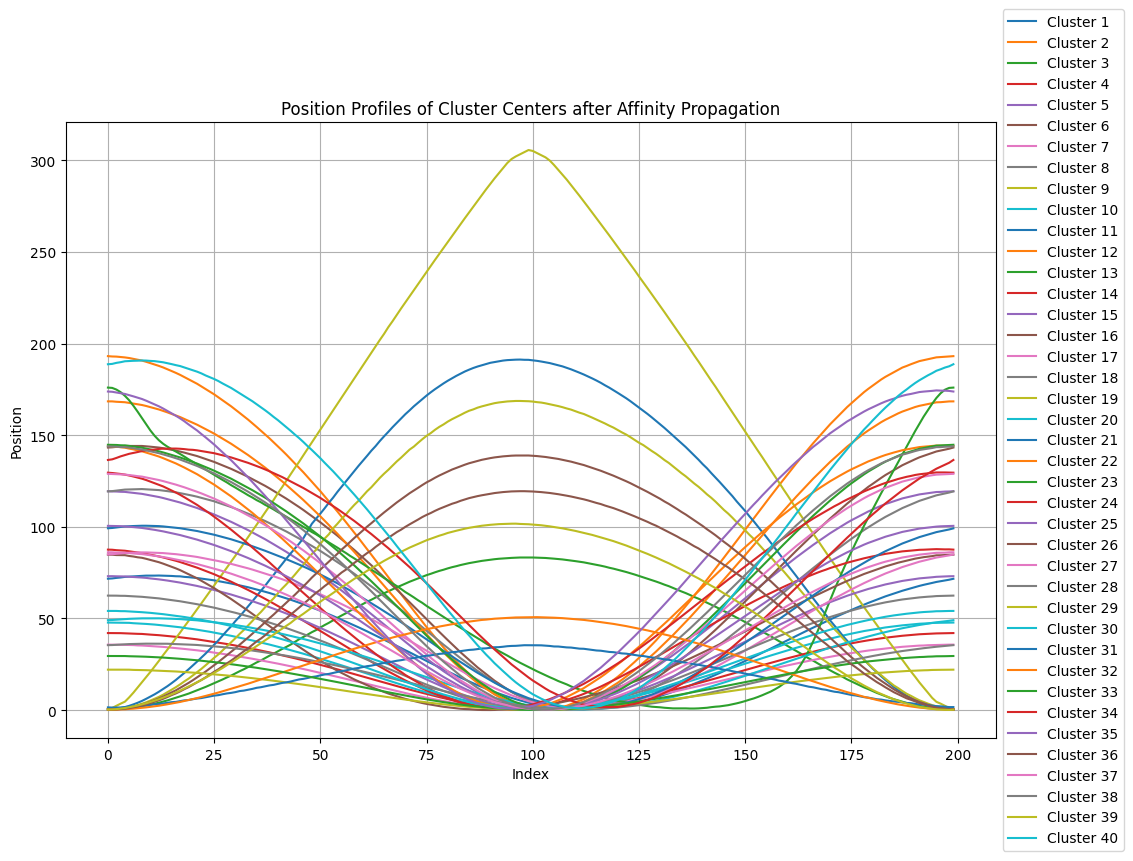

In [ ]:
# Calculating cluster center position profile for each cluster using cluster centers - centroid profiles
centroid_profiles = []
for label in np.unique(affinity_propagation_cluster_labels):
    affinity_propagation_cluster_points = position_profile_values[affinity_propagation_cluster_labels == label]
    centroid_profile = np.mean(affinity_propagation_cluster_points, axis=0)
    centroid_profiles.append(centroid_profile)

# Plot position curves of the cluster centers
plt.figure(figsize=(12, 8))
for i, centroid_profile in enumerate(centroid_profiles):
    plt.plot(centroid_profile, label=f'Cluster {i+1}')

# Adding labels and title
plt.xticks(range(0, 201, 25), range(0, 201, 25))
plt.xlabel('Index')
plt.ylabel('Position')
plt.title('Position Profiles of Cluster Centers after Affinity Propagation')
# Adding legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()